# Import
---


In [0]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets   as datasets
import torchvision.utils      as utils

# Model
---
AlexNetを基にした小さい画像用CNNモデル

In [0]:
class MyCNN(nn.Module):
    
    def __init__(self, num_classes):
        super(MyCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(  3,  32, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d( 32,  64, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d( 64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(), nn.Linear(256*6*6, 4096), nn.ReLU(inplace=True),
            nn.Dropout(), nn.Linear(   4096, 4096), nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256*6*6) # flatten
        x = self.classifier(x)
        return x

In [0]:
if torch.cuda.is_available(): device = 'cuda'
else                        : device = 'cpu' 

net = MyCNN(num_classes=10).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# Load Dataset
---

In [4]:
toTensor  = transforms.ToTensor()
normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform = transforms.Compose([toTensor, normalize])

train_set = datasets.CIFAR10(root='../data', download=True, train=True , transform=transform)
valid_set = datasets.CIFAR10(root='../data', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=1000, shuffle=True)

print('size  :', train_set[0][0].size())
print('train :', len(train_set))
print('valid :', len(valid_set))

0it [00:00, ?it/s]

 99%|█████████▉| 168583168/170498071 [00:11<00:00, 16112362.91it/s]

Files already downloaded and verified
size  : torch.Size([3, 32, 32])
train : 50000
valid : 10000


# Training & Validation
---

In [0]:
def train():
    net.train()

    # mini-batch learning
    epoch_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        # forward
        t = net(x)
        # cal loss
        loss = loss_func(t, y)
        epoch_loss += loss.item()
        # backward
        loss.backward()
        # update model
        optimizer.step()
        optimizer.zero_grad()

    return epoch_loss

In [0]:
def valid():
    net.eval()

    with torch.no_grad():
        # mini-batch validation (for save memory)
        epoch_accu = 0
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            # forward
            t = net(x)
            # cal accuracy
            _, p = torch.max(t.data, dim=1)
            accu = (p == y).sum()
            epoch_accu += accu.item()

    return epoch_accu / len(valid_set)

In [7]:
max_epoch = 30

results = []
for epoch in range(max_epoch):
    st = time.time()
    loss = train()
    md = time.time()
    accu = valid()
    ed = time.time()

    results.append([epoch+1, md-st, loss, ed-md, accu])
    print(f'{epoch+1:>2} | {md - st:5.2f}s | {loss:>7.3f} | {ed - md:5.2f}s | {accu:.2%}')

 1 | 19.14s | 101.207 |  3.38s | 32.60%
 2 | 18.77s |  81.748 |  3.37s | 42.88%
 3 | 18.71s |  68.257 |  3.43s | 54.85%
 4 | 18.72s |  59.611 |  3.41s | 59.10%
 5 | 18.71s |  53.905 |  3.38s | 62.08%
 6 | 18.74s |  48.950 |  3.43s | 65.77%
 7 | 18.64s |  44.314 |  3.37s | 67.20%
 8 | 18.66s |  40.656 |  3.42s | 68.06%
 9 | 18.67s |  38.088 |  3.50s | 70.85%
10 | 18.70s |  33.472 |  3.42s | 72.18%
11 | 18.72s |  30.565 |  3.40s | 72.95%
12 | 18.66s |  27.966 |  3.45s | 73.45%
13 | 18.70s |  25.318 |  3.41s | 73.46%
14 | 18.66s |  23.047 |  3.50s | 73.65%
15 | 18.67s |  20.610 |  3.38s | 74.63%
16 | 18.70s |  18.453 |  3.42s | 74.62%
17 | 18.65s |  16.381 |  3.44s | 75.64%
18 | 18.67s |  14.581 |  3.41s | 74.09%
19 | 18.68s |  13.582 |  3.37s | 74.63%
20 | 18.68s |  11.452 |  3.39s | 74.48%
21 | 18.68s |  10.515 |  3.45s | 75.14%
22 | 18.68s |   9.155 |  3.43s | 75.29%
23 | 18.69s |   8.745 |  3.40s | 75.03%
24 | 18.66s |   6.955 |  3.32s | 75.19%
25 | 18.69s |   6.391 |  3.38s | 75.65%


# Save Model & Result
---

In [0]:
torch.save(net.state_dict(), 'models/CIFAR10.pt')

In [0]:
columns = ['epoch', 'train time(s)', 'loss', 'valid time(s)', 'accu']
df = pd.DataFrame(data=results, columns=columns).set_index('epoch')
df.to_csv('./results/CIFAR10.csv')

# Save Targets & Predicts
---

In [0]:
net.load_state_dict(torch.load('models/CIFAR10.pt'))

ps, ys = [], []
for x, y in valid_loader:
    x, y = x.to(device), y.to(device)

    t = net(x)
    _, p = torch.max(t.data, dim=1)

    ps.append(p.cpu())
    ys.append(y.cpu())

ps = torch.cat(ps).data.detach().numpy()
ys = torch.cat(ys).data.detach().numpy()

labels = classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
ps = [labels[p] for p in ps]
ys = [labels[y] for y in ys]

In [0]:
df1 = pd.DataFrame(data={'target' :ys})
df2 = pd.DataFrame(data={'predict':ps})

df1.to_csv('outputs/target_CIFAR10.csv')
df2.to_csv('outputs/predict_CIFAR10.csv')

# Visualization of Features
---

In [0]:
def showTensor(ptimg):
    npimg = ptimg.cpu().detach().numpy()

    # if npimg.shape == ()
    # plt.imshow(npimg)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [24]:
x = valid_set[0][0].unsqueeze(dim=0)
x = x.to(device)

showTensor(x)

ValueError: ignored

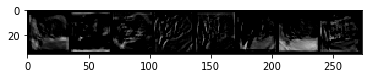

In [23]:
x = valid_set[0][0].unsqueeze(dim=0)
x = x.to(device)

t = net.features[:](x)

imgs = t[0][:8]
c,h,w = imgs.size()
imgs = imgs.view(c, 1, h, w)

pad = round(h / 20)
grid = utils.make_grid(imgs, padding=pad)
showTensor(grid)